# Mapping Monthly Emission Flux Over the Amazon

This script processes and visualizes monthly emission flux data for different atmospheric pollutants over the Amazon region. The data is extracted from preprocessed CSV files, filtered by year and month, and mapped onto a spatial grid using latitude and longitude coordinates. The final result is a heatmap representation of emission fluxes, with a color scale indicating intensity.

1. **Defining Data Directory and Selecting Year/Month**: 
The user specifies the directory containing the emission data and selects a specific year and month for analysis. The script locates the corresponding CSV files and extracts relevant columns, including pollutant flux values.

2. **Selecting the Pollutant for Analysis**: 
The script allows the user to choose from four types of emission fluxes:  
- **Total Particulate Matter (TPM)**  
- **Carbon Dioxide (CO₂)**  
- **Carbon Monoxide (CO)**  
- **Methane (CH₄)**  

The selected pollutant's data is then extracted for further processing.

3. **Structuring Data for Mapping**: 
Latitude and longitude values from the dataset are used to construct a spatial grid. The emission flux data is assigned to the corresponding grid points, forming a structured matrix representing the emission distribution.
  
4. **Visualizing the Emission Flux Map**: 
A **heatmap** is generated using `matplotlib` to represent emission flux intensity. The plot includes:  
- **Color-coded emission levels** with a colormap (`viridis`).  
- **Longitude and latitude axes** with proper formatting.  
- **A colorbar** to indicate flux values.  

The final figure is saved as a high-resolution `.png` file.


In [ ]:
# Import necessary libraries
# Data handling and analysis
import pandas as pd  
import numpy as np  
# Plotting and visualization
import matplotlib.pyplot as plt  
from mpl_toolkits.axes_grid1 import make_axes_locatable  # For customized subplot layouts
from mpl_toolkits.axes_grid1.axes_divider import make_axes_area_auto_adjustable  # Auto-adjust subplot sizes
import matplotlib.ticker as mticker
# File handling
import glob  
# Mathematical operations
import math as mt  
# Signal processing functions
from scipy.signal import chirp, find_peaks, peak_widths, find_peaks_cwt  

In [ ]:
# Define the directory containing processed emission data
datadir = '/Path'

# Specify the year and month for data processing
Year = 2022
Month = 8
# Example file naming convention: "amazon_2020_mean_montly_flux.csv"

# Retrieve a sorted list of files matching the specified year
data = sorted(glob.glob(datadir + f'/*amazon_{Year}_mean_montly_flux.csv'))

# Column names available in the dataset:
# year, month, central_lat, central_lon, Area(m^2), FRP/Area(MW/m^2s), 
# TPM_flux(kg/m^2s), CO2_flux(kg/m^2s), CO_flux(kg/m^2s), CH4_flux(kg/m^2s)

# Select only relevant columns for analysis
selected_columns = ['year', 'month', 'central_lat', 'central_lon', 
                    'TPM_flux(kg/m^2s)', 'CO2_flux(kg/m^2s)', 'CO_flux(kg/m^2s)', 'CH4_flux(kg/m^2s)']

# Read the first CSV file, extracting only the selected columns
emission_data = pd.read_csv(data[0], usecols=selected_columns)

In [ ]:
# Define the types of emissions available for monthly flux calculations
# The material_list contains four types: TPM, CO2, CO, and CH4 flux
material_list = ['TPM_flux(kg/m^2s)', 'CO2_flux(kg/m^2s)', 'CO_flux(kg/m^2s)', 'CH4_flux(kg/m^2s)']

# Select the first material type (TPM) for plotting the emission flux map
material = material_list[0]
material_name = material.split('_')[0]  # Extract the material name (e.g., 'TPM') for labeling

# Assign the dataset for processing
dados_emission = emission_data

# Define the output filename based on the selected material
filename = 'Amazon_box_' + material_name + '_emission_flux_mapping'

# Assign year and month variables for filtering data
y = Year
m = Month

# Extract column headers from the dataset
header = list(dados_emission)

# Extract the year column
pos1 = header.index('year')
column1 = dados_emission.iloc[:, pos1]
year = np.array(column1.dropna(), dtype=pd.Series)

# Extract the month column
pos3 = header.index('month')
column3 = dados_emission.iloc[:, pos3]
month = np.array(column3.dropna(), dtype=pd.Series)

# Extract the latitude column
pos2 = header.index('central_lat')
column2 = dados_emission.iloc[:, pos2]
lat = np.array(column2.dropna(), dtype=pd.Series)

# Extract the longitude column
pos4 = header.index('central_lon')
column4 = dados_emission.iloc[:, pos4]
lon = np.array(column4.dropna(), dtype=pd.Series)

# Extract the selected emission flux column
pos5 = header.index(material)
column5 = dados_emission.iloc[:, pos5]
Material_flux = np.array(column5.dropna(), dtype=pd.Series)

# Define unique latitude and longitude values for grid mapping
lats = np.unique(lat)
lons = np.unique(lon)
lats = lats[::-1]  # Reverse latitude order to match mapping conventions

# Initialize the emission flux matrix with zeros, matching the grid size
matrix_Material = np.zeros((len(lats), len(lons)), dtype='float64')

# Populate the matrix with the corresponding monthly emission flux values
for k in range(0, len(lats)):
    Progress = 'Progress: {:.1f}lat/{:.1f}lats'.format(k, len(lats))
    print(Progress)  # Display progress message
    for n in range(0, len(lons)):
        # Find the index where latitude, longitude, year, and month match the criteria
        index = np.where((lat == lats[k]) & (lon == lons[n]) & (year == y) & (month == m))
        
        # Assign the corresponding emission flux value to the grid cell
        matrix_Material[k, n] = Material_flux[index]

In [ ]:
# Define the function to format latitude and longitude
def format_latitude(y, _):
    return f"{abs(y):.0f}°S" if y < 0 else f"{y:.0f}°N"

def format_longitude(x, _):
    return f"{abs(x):.0f}°W" if x < 0 else f"{x:.0f}°E"

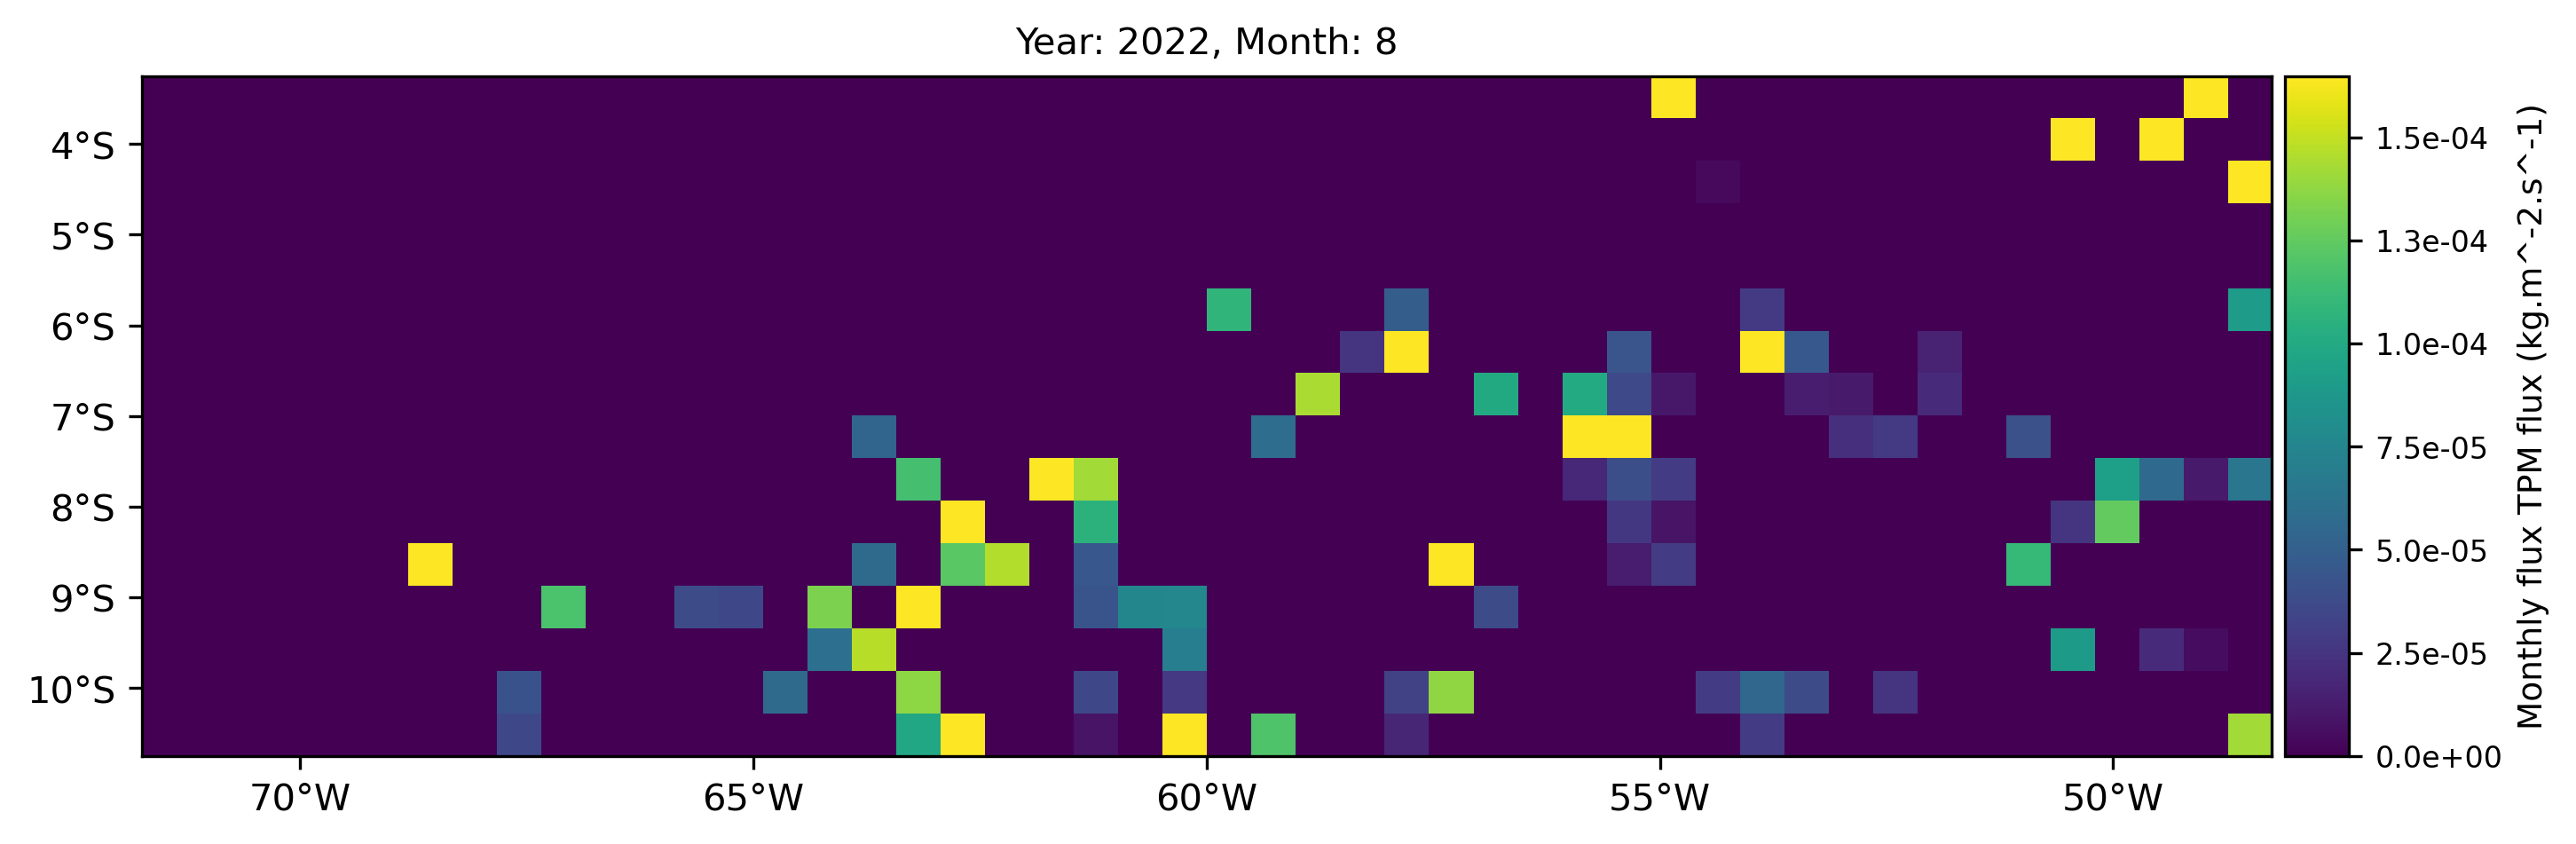

In [5]:
# Configure the plot
fig, ax = plt.subplots(figsize=(10, 3), dpi=300)  # Set figure size and resolution

# Define the spatial extent of the plot (longitude and latitude boundaries)
extend = np.min(lons), np.max(lons), np.min(lats), np.max(lats)

# Plot the emission flux matrix as an image with a 'viridis' colormap
# The color scale is set between the 0th and 98th percentile to remove outliers
im = ax.imshow(matrix_Material, cmap='viridis', extent=extend,
               vmin=np.percentile(matrix_Material, 0), 
               vmax=np.percentile(matrix_Material, 98))

# Set the title of the plot with the selected year and month
Title = 'Year: {}, Month: {}'.format(np.unique(year)[0], m)
ax.set_title(Title, fontsize=10)

# Format the x-axis and y-axis labels to display longitude and latitude properly
ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_longitude))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_latitude))

# Create a colorbar next to the plot to represent emission flux values
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)  # Adjust colorbar size and padding

# Define colorbar limits and tick intervals
vmin = np.percentile(matrix_Material, 0)
vmax = np.percentile(matrix_Material, 98)
tick_interval = 0.000025  # Adjust if needed for better readability

# Create the colorbar with scientific notation formatting
cb = plt.colorbar(im, cax=cax, format='%.1e')
cb.set_label('Monthly flux TPM flux (kg.m^-2.s^-1)', fontsize=9)  # Label the colorbar
cb.ax.tick_params(labelsize=8)  # Set tick label size
cb.set_ticks(np.arange(vmin, vmax, tick_interval))  # Define tick locations

# Adjust layout to ensure all elements fit well in the figure
plt.subplots_adjust(left=0.40, right=0.85, top=0.8, bottom=0.25)  # Modify as needed
plt.tight_layout()
plt.show()
# Save the figure as a PNG file with high resolution
#plt.savefig(filename + '.png', dpi=300)
